imports

In [ ]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def visualize(image,mask):
    image=image.squeeze().numpy()
    mask=mask.squeeze().numpy()
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(image,cmap="gray")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask,cmap="gray")
    plt.axis("off")
    plt.show()

dataset definition

In [ ]:
class SegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = os.listdir(image_dir)
        self.mask_filenames = os.listdir(mask_dir)

    def __len__(self):
        return len(self.mask_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        mask_name = self.mask_filenames[idx]

        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Load images
        image = Image.open(img_path).convert("L")  # Grayscale
        mask = Image.open(mask_path).convert("L")  # Grayscale
        # Apply transformations
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)  # Apply the same transform to mask
            image= image/image.max()
            mask = (mask > 0.5).float()
        return image, mask



In [ ]:
image_dir=r"/content/brain_tumour_data/images"
mask_dir=r"/content/brain_tumour_data/masks"

In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/brain_tumour.zip"
extract_path = "/content/brain_tumour_data" # Or any other desired path

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Successfully extracted {zip_path} to {extract_path}")

Successfully extracted /content/drive/MyDrive/brain_tumour.zip to /content/brain_tumour_data


In [ ]:
transform=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

In [ ]:
dataset=SegDataset(image_dir=image_dir,mask_dir=mask_dir,transform=transform)

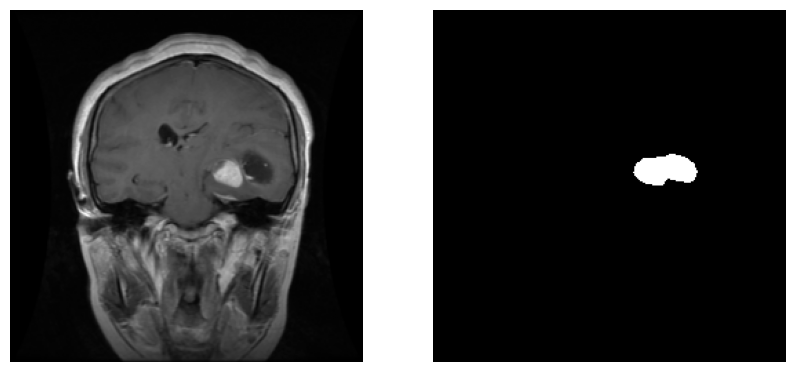

In [ ]:
image,mask=dataset[4]
visualize(image,mask)

In [ ]:
dataloader=DataLoader(dataset,batch_size=16,shuffle=True,pin_memory=True)

In [ ]:
image, mask = dataset[0]  # Get a sample image and mask
print(f"Image tensor -> min: {image.min()}, max: {image.max()}")
print(f"Mask tensor -> min: {mask.min()}, max: {mask.max()}")


Image tensor -> min: 0.0, max: 1.0
Mask tensor -> min: 0.0, max: 1.0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
for images, masks in dataloader:
    print(f"Image Shape: {images.shape} | Mask Shape: {masks.shape}")
    break


Image Shape: torch.Size([16, 1, 256, 256]) | Mask Shape: torch.Size([16, 1, 256, 256])


for train

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_ch, out_ch)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class MINet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.inc = ConvBlock(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)

        self.up1 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        return torch.sigmoid(self.out_conv(x))
    # Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model instance
model = MINet(in_channels=1, out_channels=1).to(device)


f3net

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class AggregationModule(nn.Module):
    def __init__(self, in_channels):
        super(AggregationModule, self).__init__()
        self.conv1 = BasicConv2d(in_channels, 64, 3, padding=1)
        self.conv2 = BasicConv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, 1)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

class F3NetLite(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(F3NetLite, self).__init__()

        # Encoder
        self.enc1 = nn.Sequential(BasicConv2d(in_channels, 32, 3, padding=1), BasicConv2d(32, 64, 3, padding=1))
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(BasicConv2d(64, 128, 3, padding=1), BasicConv2d(128, 128, 3, padding=1))
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = nn.Sequential(BasicConv2d(128, 256, 3, padding=1), BasicConv2d(256, 256, 3, padding=1))
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = BasicConv2d(256, 512, 3, padding=1)

        # Decoder
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec2 = BasicConv2d(512, 256, 3, padding=1)

        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = BasicConv2d(256, 128, 3, padding=1)

        self.up0 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec0 = BasicConv2d(128, 64, 3, padding=1)

        # Output
        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)       # -> [B, 64, 256, 256]
        p1 = self.pool1(e1)     # -> [B, 64, 128, 128]

        e2 = self.enc2(p1)      # -> [B, 128, 128, 128]
        p2 = self.pool2(e2)     # -> [B, 128, 64, 64]

        e3 = self.enc3(p2)      # -> [B, 256, 64, 64]
        p3 = self.pool3(e3)     # -> [B, 256, 32, 32]

        b = self.bottleneck(p3) # -> [B, 512, 32, 32]

        # Decoder
        d2 = self.up2(b)        # -> [B, 256, 64, 64]
        d2 = self.dec2(torch.cat([d2, e3], dim=1))

        d1 = self.up1(d2)       # -> [B, 128, 128, 128]
        d1 = self.dec1(torch.cat([d1, e2], dim=1))

        d0 = self.up0(d1)       # -> [B, 64, 256, 256]
        d0 = self.dec0(torch.cat([d0, e1], dim=1))

        out = self.final(d0)    # -> [B, 1, 256, 256]
        return out
model = F3NetLite(in_channels=1, out_channels=1).to("cuda")


basnet

In [ ]:
import torchvision.models.segmentation as models
import torch.nn as nn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# A simplified BASNet architecture
class BASNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(BASNet, self).__init__()

        # Encoder
        self.conv1 = self._conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = self._conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = self._conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.bottleneck = self._conv_block(256, 512)

        # Decoder
        self.up3 = self._up_block(512, 256)
        self.up2 = self._up_block(256, 128)
        self.up1 = self._up_block(128, 64)

        # Final prediction
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def _up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            self._conv_block(out_channels, out_channels)
        )

    def forward(self, x):
        # Encoder
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool1(x1))
        x3 = self.conv3(self.pool2(x2))

        # Bottleneck
        x4 = self.bottleneck(self.pool3(x3))

        # Decoder
        d3 = self.up3(x4)
        d2 = self.up2(d3)
        d1 = self.up1(d2)

        out = self.final(d1)
        return torch.sigmoid(out)  # for binary segmentation

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BASNet(in_channels=1, out_channels=1).to(device)
print(model)


BASNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=F

deeplab v3

In [ ]:
import torchvision.models.segmentation as models
import torch.nn as nn
class DeepLabV3Plus(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(DeepLabV3Plus, self).__init__()
        self.backbone = models.deeplabv3_resnet50(pretrained=False)
        self.backbone.classifier[4] = nn.Conv2d(256, out_channels, kernel_size=1)

        # Modify input channels to 1
        first_layer = self.backbone.backbone.conv1
        self.backbone.backbone.conv1 = nn.Conv2d(in_channels, first_layer.out_channels, kernel_size=7, stride=2, padding=3, bias=False)

    def forward(self, x):
        return torch.sigmoid(self.backbone(x)["out"])

# Example
model = DeepLabV3Plus().cuda()
print(model)


unet

In [ ]:


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):  # 1 for grayscale, adjust out_channels for multi-class
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, 3, padding=1), nn.ReLU(),
                                   nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
                                   nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.conv3 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
                                   nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())

        # Decoder
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv4 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(),
                                   nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv5 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
                                   nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())

        # Output layer
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)  # No activation here

    def forward(self, x):
        # Encoder
        x1 = self.conv1(x)
        p1 = self.pool1(x1)

        x2 = self.conv2(p1)
        p2 = self.pool2(x2)

        # Bottleneck
        x3 = self.conv3(p2)

        # Decoder
        u2 = self.upconv2(x3)
        x4 = self.conv4(torch.cat([u2, x2], dim=1))

        u1 = self.upconv1(x4)
        x5 = self.conv5(torch.cat([u1, x1], dim=1))

        # Output
        return self.out(x5)

# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1).to(device)  # Use 1 channel for binary segmentation
print(model)


UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (upconv2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv4): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()

In [ ]:
# Ensure the model is on the same device as the input
model = model.to(device)

sample_input = torch.randn(16, 1, 256, 256).to(device)  # Simulating a batch
model.to(device)
sample_input.to(device)
output = model(sample_input)
print(f"Model Output Shape: {output.shape}")


Model Output Shape: torch.Size([16, 1, 256, 256])


In [ ]:
from torch.utils.data import random_split

dataset_size = len(dataset)
train_size = int(0.85 * dataset_size)  # 80% for training
val_size = dataset_size - train_size  # 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Training Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)}")


Training Samples: 2604, Validation Samples: 460


In [ ]:
from torch.utils.data import DataLoader

batch_size = 16  # Adjust based on your GPU memory

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torch.optim as optim

criterion=nn.BCEWithLogitsLoss()
optimizer=optim.Adam(model.parameters(),lr=1e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5)

In [ ]:
def dice_coefficient(pred, target, epsilon=1e-6):
    pred_binary = (pred > 0.5).float()
    intersection = (pred_binary * target).sum()
    return (2. * intersection + epsilon) / (pred_binary.sum() + target.sum() + epsilon)

def iou_score(pred, target, epsilon=1e-6):
    pred_binary = (pred > 0.5).float()
    intersection = (pred_binary * target).sum()
    union = pred_binary.sum() + target.sum() - intersection
    return (intersection + epsilon) / (union + epsilon)

def accuracy(pred, target, epsilon=1e-6):
    pred_binary = (pred > 0.5).float()
    target_binary = (target > 0.5).float()

    tumor_pixels = target_binary.sum()  # Count only tumor pixels
    if tumor_pixels == 0:
        return 1.0  # If no tumor is present, accuracy is perfect (trivial case)

    correct_tumor = ((pred_binary == target_binary) * target_binary).sum()
    return (correct_tumor + epsilon) / (tumor_pixels + epsilon)  # Accuracy only for tumor pixels

In [ ]:
from torch.utils.data import Subset

subset_size = 3000 # Use only 1000 images
indices = torch.randperm(len(dataset))[:subset_size].tolist()  # Random subset
small_dataset = Subset(dataset, indices)

# Split into train & val
train_size = int(0.85 * subset_size)
val_size = subset_size - train_size
train_dataset, val_dataset = random_split(small_dataset, [train_size, val_size])


In [ ]:
print(f"Training Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)}")

Training Samples: 2550, Validation Samples: 450


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Training loop with metrics tracking
epochs = 30
losses = []
dice_scores = []
iou_scores = []

for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_dice = 0.0
    epoch_iou = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        ouptputs = torch.clamp(outputs, min=0, max=1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_dice += dice_coefficient(outputs, masks).item()
        epoch_iou += iou_score(outputs, masks).item()

    losses.append(epoch_loss / len(train_loader))
    dice_scores.append(epoch_dice / len(train_loader))
    iou_scores.append(epoch_iou / len(train_loader))

    print(f"Epoch {epoch+1}/{epochs}, Loss: {losses[-1]:.4f}, Dice: {dice_scores[-1]:.4f}, IoU: {iou_scores[-1]:.4f}")


Epoch 1/30, Loss: 0.0652, Dice: 0.0000, IoU: 0.0000
Epoch 2/30, Loss: 0.0638, Dice: 0.0000, IoU: 0.0000
Epoch 3/30, Loss: 0.0619, Dice: 0.0000, IoU: 0.0000
Epoch 4/30, Loss: 0.0610, Dice: 0.0344, IoU: 0.0185
Epoch 5/30, Loss: 0.0599, Dice: 0.0431, IoU: 0.0235
Epoch 6/30, Loss: 0.0581, Dice: 0.1164, IoU: 0.0645
Epoch 7/30, Loss: 0.0568, Dice: 0.1359, IoU: 0.0762
Epoch 8/30, Loss: 0.0550, Dice: 0.1669, IoU: 0.0950
Epoch 9/30, Loss: 0.0541, Dice: 0.1811, IoU: 0.1039
Epoch 10/30, Loss: 0.0519, Dice: 0.2177, IoU: 0.1260


In [ ]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np

# # Function to visualize random predictions using DataLoader
# def visualize_random_predictions(model, val_loader, num_samples=5, device="cuda"):
#     model.eval()  # Set model to evaluation mode

#     images_list, masks_list, preds_list = [], [], []

#     with torch.no_grad():
#         for images, masks in val_loader:  # Load a batch from the DataLoader
#             images, masks = images.to(device), masks.to(device)
#             preds = torch.sigmoid(model(images))  # Get predictions
#             preds = torch.clamp(preds, min=0, max=1)  # Ensure values are in [0,1]

#             images_list.extend(images.cpu())   # Store images
#             masks_list.extend(masks.cpu())     # Store ground truth masks
#             preds_list.extend(preds.cpu())     # Store predicted masks

#             if len(images_list) >= num_samples:  # Stop when we have enough samples
#                 break

#     # Pick random indices from the collected samples
#     indices = torch.randperm(len(images_list))[:num_samples]

#     fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

#     for i, idx in enumerate(indices):
#         image = images_list[idx].squeeze().numpy()   # Convert to NumPy
#         mask = masks_list[idx].squeeze().numpy()
#         pred_mask = preds_list[idx].squeeze().numpy()

#         # Overlay predicted mask on the input image
#         overlay = np.stack([image, image, image], axis=-1)  # Convert grayscale to RGB
#         overlay[..., 1] = np.maximum(overlay[..., 1], pred_mask)  # Highlight prediction in green

#         # Input Image
#         axes[i, 0].imshow(image, cmap='gray')
#         axes[i, 0].set_title("Input Image")
#         axes[i, 0].axis("off")

#         # Ground Truth Mask
#         axes[i, 1].imshow(mask, cmap='gray')
#         axes[i, 1].set_title("Ground Truth Mask")
#         axes[i, 1].axis("off")

#         # Predicted Mask Overlay
#         axes[i, 2].imshow(overlay)
#         axes[i, 2].set_title("Predicted Mask Overlay")
#         axes[i, 2].axis("off")

#     plt.tight_layout()
#     plt.show()
import torch
import matplotlib.pyplot as plt

# Function to visualize random predictions using DataLoader
def visualize_random_predictions(model, val_loader, num_samples=5, device="cuda"):
    model.eval()  # Set model to evaluation mode

    images_list, masks_list, preds_list = [], [], []

    with torch.no_grad():
        for images, masks in val_loader:  # Load a batch from the DataLoader
            images, masks = images.to(device), masks.to(device)
            preds = torch.sigmoid(model(images))  # Get predictions
            preds = torch.clamp(model(images), min=0, max=1)
            images_list.extend(images.cpu())   # Store images
            masks_list.extend(masks.cpu())     # Store ground truth masks
            preds_list.extend(preds.cpu())     # Store predicted masks

            if len(images_list) >= num_samples:  # Stop when we have enough samples
                break

    # Pick random indices from the collected samples
    indices = torch.randperm(len(images_list))[:num_samples]

    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i, idx in enumerate(indices):
        image = images_list[idx].squeeze().numpy()   # Convert to NumPy
        mask = masks_list[idx].squeeze().numpy()
        pred_mask = preds_list[idx].squeeze().numpy()

        # Input Image
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis("off")

        # Ground Truth Mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        # Predicted Mask
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

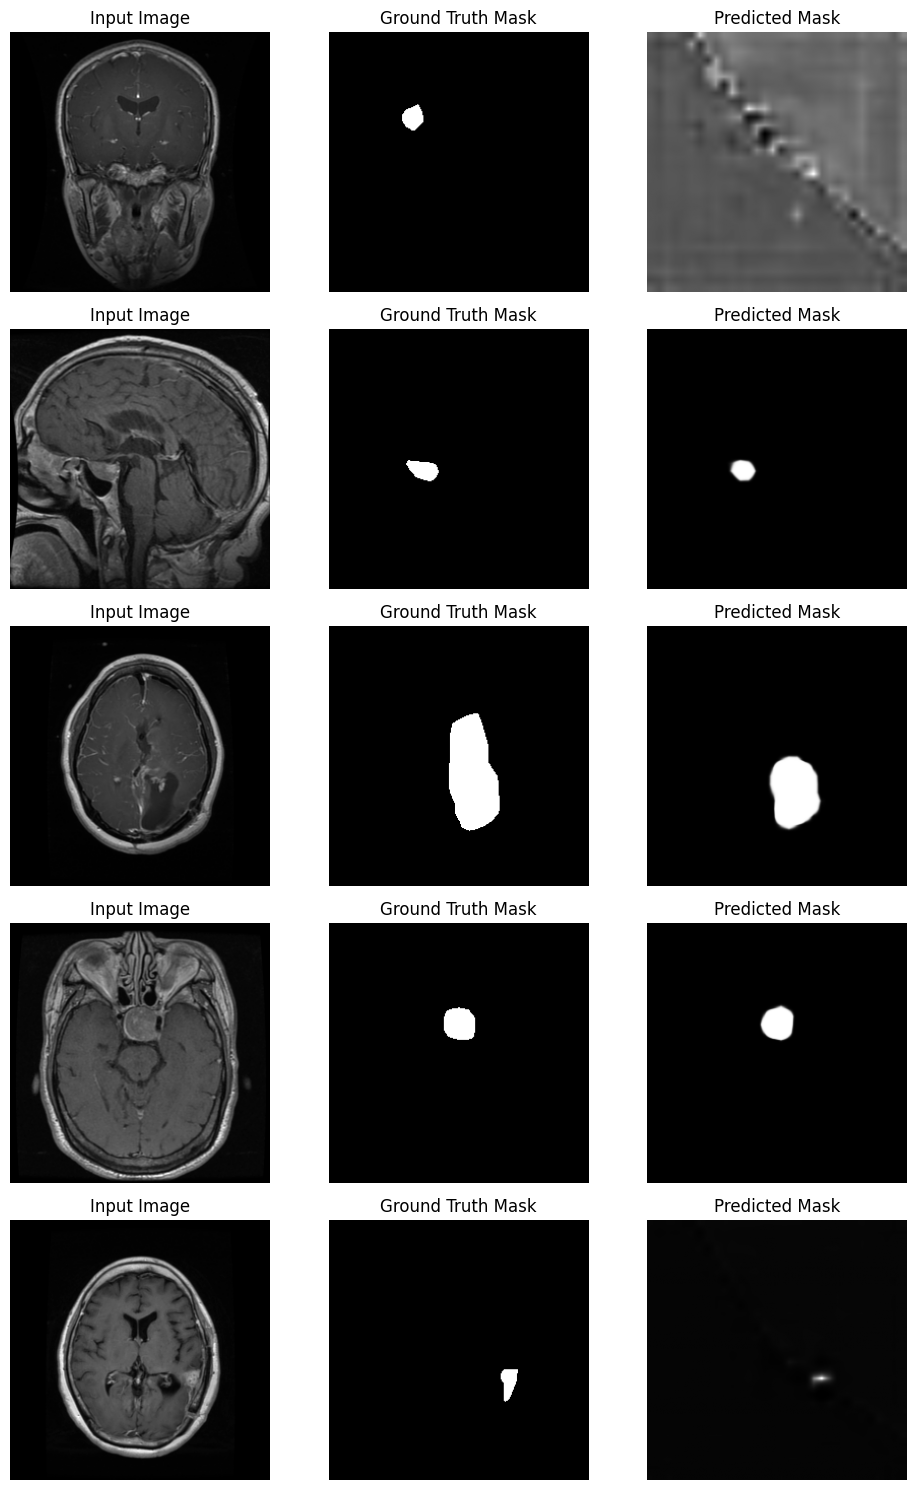

In [ ]:
visualize_random_predictions(model=model,val_loader=val_loader,num_samples=5,device="cuda")

In [ ]:
torch.save(model.state_dict(), "brain_tumor_segmentation_1.7.pth")

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    total_dice, total_iou, total_loss = 0, 0, 0
    criterion = nn.BCELoss()

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks).item()
            dice = dice_coefficient(outputs, masks).item()
            iou = iou_score(outputs, masks).item()

            total_loss += loss
            total_dice += dice
            total_iou += iou

    avg_loss = total_loss / len(test_loader)
    avg_dice = total_dice / len(test_loader)
    avg_iou = total_iou / len(test_loader)

    print(f"Test Loss: {avg_loss:.4f}, Dice Score: {avg_dice:.4f}, IoU: {avg_iou:.4f}")


load model

In [ ]:
model = AttentionUNet()  # Initialize the model
model.load_state_dict(torch.load("C:/coding python/brain_tumor_segmentation_1.3.pth"))
model.eval()  # Set to evaluation mode
model.to(device)

AttentionUNet(
  (encoder1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
def mse_loss(pred, target):
    return torch.mean((pred - target) ** 2)


In [ ]:
def pearson_correlation(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)

    mean_pred = torch.mean(pred)
    mean_target = torch.mean(target)

    numerator = torch.sum((pred - mean_pred) * (target - mean_target))
    denominator = torch.sqrt(torch.sum((pred - mean_pred) ** 2) * torch.sum((target - mean_target) ** 2) + 1e-6)

    return numerator / denominator


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    model.to(device)  # Move model to device
    total_mse, total_ssim, total_corr, total_loss = 0, 0, 0, 0
    criterion = nn.MSELoss()  # Use MSE instead of BCE Loss

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = torch.clamp(model(images), min=0, max=1)

            loss = criterion(outputs, masks).item()
            mse = mse_loss(outputs, masks).item()
            corr = pearson_correlation(outputs, masks).item()

            total_loss += loss
            total_mse += mse
            total_corr += corr

    avg_loss = total_loss / len(test_loader)
    avg_mse = total_mse / len(test_loader)
    avg_corr = total_corr / len(test_loader)

    print(f"Test Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, Pearson Corr: {avg_corr:.4f}")


In [ ]:
evaluate_model(model,val_loader)

Test Loss: 0.0074, MSE: 0.0074, Pearson Corr: 0.7754


In [ ]:

# Load the .pth file
pth_path = 'brain_tumor_segmentation_1.3.pth'
checkpoint = torch.load(pth_path, map_location='cpu')

# If it's a state_dict
if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    state_dict = checkpoint

# Print the keys
for key in state_dict.keys():
    print(key)



encoder1.conv.0.weight
encoder1.conv.1.weight
encoder1.conv.1.bias
encoder1.conv.1.running_mean
encoder1.conv.1.running_var
encoder1.conv.1.num_batches_tracked
encoder1.conv.3.weight
encoder1.conv.4.weight
encoder1.conv.4.bias
encoder1.conv.4.running_mean
encoder1.conv.4.running_var
encoder1.conv.4.num_batches_tracked
encoder2.conv.0.weight
encoder2.conv.1.weight
encoder2.conv.1.bias
encoder2.conv.1.running_mean
encoder2.conv.1.running_var
encoder2.conv.1.num_batches_tracked
encoder2.conv.3.weight
encoder2.conv.4.weight
encoder2.conv.4.bias
encoder2.conv.4.running_mean
encoder2.conv.4.running_var
encoder2.conv.4.num_batches_tracked
encoder3.conv.0.weight
encoder3.conv.1.weight
encoder3.conv.1.bias
encoder3.conv.1.running_mean
encoder3.conv.1.running_var
encoder3.conv.1.num_batches_tracked
encoder3.conv.3.weight
encoder3.conv.4.weight
encoder3.conv.4.bias
encoder3.conv.4.running_mean
encoder3.conv.4.running_var
encoder3.conv.4.num_batches_tracked
bridge.conv.0.weight
bridge.conv.1.weigh